In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import sklearn.preprocessing
import pyreadr
from threadpoolctl import threadpool_limits, threadpool_info
import os

import jax.numpy as jnp
from tqdm.contrib.concurrent import process_map
import itertools

/data/scratch/sturm/conda/envs/shears_dev/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
threadpool_info()

[{'user_api': 'blas',
  'internal_api': 'openblas',
  'prefix': 'libopenblas',
  'filepath': '/data/scratch/sturm/conda/envs/shears_dev/lib/libopenblasp-r0.3.21.so',
  'version': '0.3.21',
  'threading_layer': 'pthreads',
  'architecture': 'Haswell',
  'num_threads': 1},
 {'user_api': 'openmp',
  'internal_api': 'openmp',
  'prefix': 'libgomp',
  'filepath': '/data/scratch/sturm/conda/envs/shears_dev/lib/libgomp.so.1.0.0',
  'version': None,
  'num_threads': 1}]

In [3]:

threadpool_limits(8)

In [4]:
# adata = sc.read_h5ad("/home/sturm/projects/2020/pircher-scrnaseq-lung/data/20_build_atlas/add_additional_datasets/03_update_annotation/artifacts/full_atlas_merged.h5ad")
# adata = adata[adata.obs["origin"] == "tumor_primary", :]
# sc.pp.subsample(adata, n_obs=20000)
# adata.write_h5ad("data/luca_20k.h5ad")

In [5]:
tcga = pyreadr.read_r(
    "/home/sturm/projects/2020/pircher-scrnaseq-lung/data/13_tcga/for_scissor/nsclc_primary_tumor.rds"
)[None]
adata_tcga = sc.AnnData(tcga.T)

/local/scratch/sturm/ipykernel_14309/2816675499.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_tcga = sc.AnnData(tcga.T)


In [6]:
tcga_meta = pd.read_csv(
    "/home/sturm/projects/2020/pircher-scrnaseq-lung/tables/tcga/clinical_data_for_scissor.tsv",
    sep="\t",
).set_index("TCGA_patient_barcode")
adata_tcga.obs = adata_tcga.obs.join(tcga_meta)

In [7]:
adata_sc = sc.read_h5ad("data/luca_20k.h5ad")

In [8]:
common_genes = list(sorted(set(adata_tcga.var_names) & set(adata_sc.var_names)))

In [9]:
adata_tcga = adata_tcga[:, common_genes].copy()
adata_sc = adata_sc[:, common_genes].copy()

In [10]:
adata_sc.layers["quantile_norm"] = sklearn.preprocessing.quantile_transform(adata_sc.X)
adata_tcga.layers["quantile_norm"] = sklearn.preprocessing.quantile_transform(
    adata_tcga.X
)

In [11]:
adata_sc.layers["quantile_norm"]

<20000x17460 sparse matrix of type '<class 'numpy.float32'>'
	with 24714839 stored elements in Compressed Sparse Column format>

In [68]:
# corr_result = np.corrcoef(adata_sc.layers["quantile_norm"].toarray(), adata_tcga.layers["quantile_norm"])

In [13]:
corr_result = jnp.corrcoef(
    adata_tcga.layers["quantile_norm"], adata_sc.layers["quantile_norm"].toarray()
)

In [71]:
corr_mat = corr_result[: adata_tcga.shape[0], adata_tcga.shape[0] :]

In [72]:
corr_mat.shape

(1014, 20000)

In [16]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [17]:
corr_iter = list(corr_mat[:, i] for i in range(corr_mat.shape[1]))

In [18]:
def check_cell(corr, df):
    df["corr"] = corr
    res = smf.glm(
        "C(type) ~ corr + C(gender) + age + C(tumor_stage_ajcc)",
        data=df,
        family=sm.families.Binomial(),
    ).fit()
    return res.pvalues["corr"], res.params["corr"]

In [19]:
df = adata_tcga.obs.loc[
    :, ["type", "tp53_mutation", "gender", "age", "tumor_stage_ajcc"]
]

In [20]:
all_res = process_map(
    check_cell, corr_iter, itertools.repeat(df), chunksize=100, max_workers=32
)

100%|██████████| 20000/20000 [00:26<00:00, 747.12it/s] 


In [21]:
all_res = np.array(all_res)

In [22]:
adata_sc.obs["pvalue_sign"] = -np.log10(all_res[:, 0]) * np.sign(all_res[:, 1])
adata_sc.obs["coef"] = all_res[:, 1]
adata_sc.obs["coef_signif"] = [
    x if p < 0.0001 else np.nan for x, p in zip(all_res[:, 1], all_res[:, 0])
]

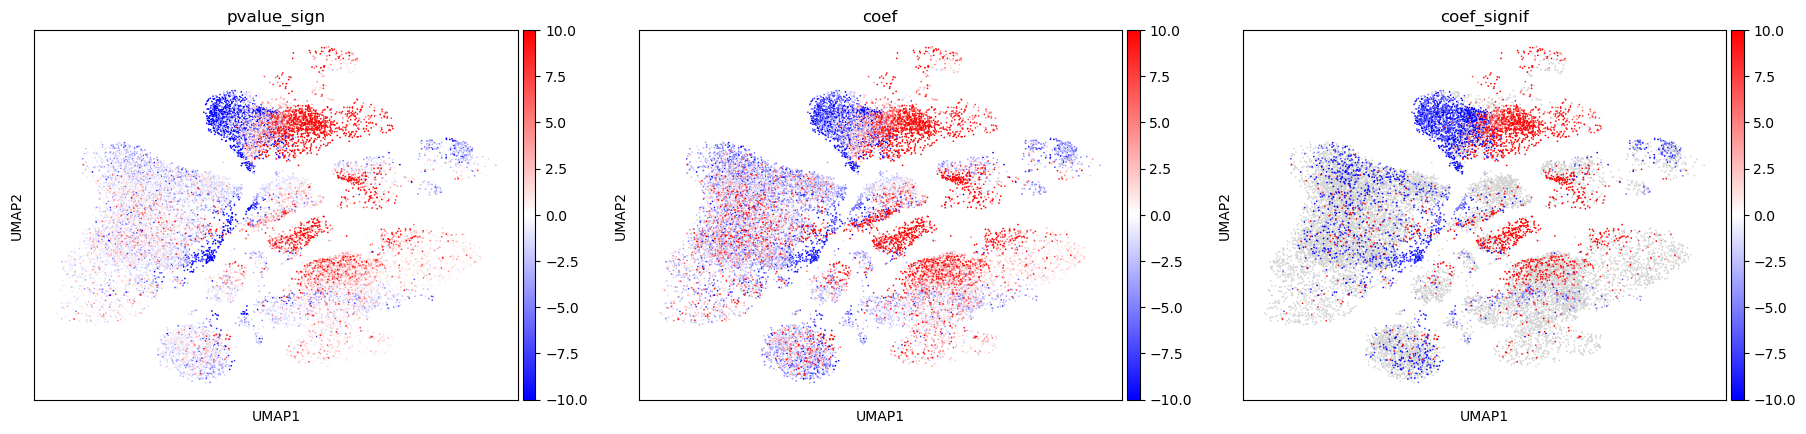

In [23]:
sc.pl.umap(
    adata_sc,
    color=["pvalue_sign", "coef", "coef_signif"],
    cmap="bwr",
    vmin=-10,
    vmax=10,
)

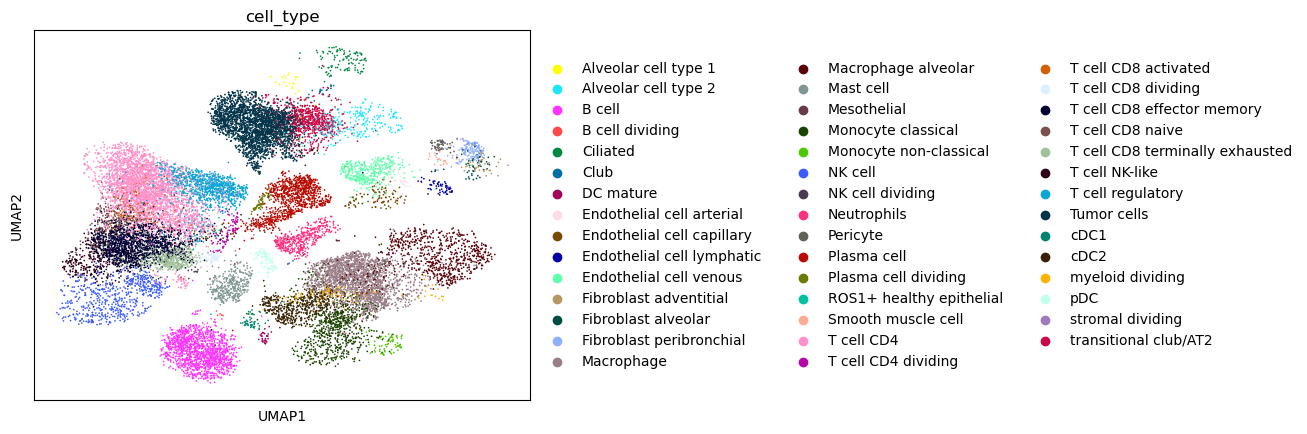

In [24]:
sc.pl.umap(adata_sc, color=["cell_type"])